In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

In [ ]:
!sudo apt-get install unixodbc-dev
!pip install pyodbc
!pip install chart_studio

In [ ]:
import pyodbc
server = 'dmagroup22.database.windows.net'
database = 'dmadb'
username = 'CloudSA169ab7fd'
password = '{DMAGroup22}'   
driver= '{ODBC Driver 17 for SQL Server}'
conn_string = 'DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password

1) Find the amount of money collected by the Wealth Management division from each High Networth individual- this includes the wealth cut and all the fees of services availed.

               Name   Total Pay
0      Juana Crider  30014918.0
1   Darrion Matlock  50025008.0
2   Britney Redmond  30027761.0
3     Tristin Morse  20015599.0
4  Annalise Fleming  90023574.0


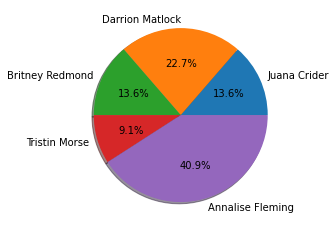

In [ ]:
wm_df = pd.DataFrame()
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("with total_fees as (select HNI_id, sum(fee) as total_fees_collected from dma.WMprovision GROUP by HNI_id) select wc.HNI_id, c.name, (tf.total_fees_collected + wc.wealthcut) as total_hni_pay from dma.wealthcut wc join total_fees tf on wc.HNI_id=tf.HNI_id join dma.client c on wc.HNI_id = c.ID;")
        columns = [column[0] for column in cursor.description]
        row = cursor.fetchone()
        i=0
        while row:
            wm_df.loc[i,'Name'] = str(row[1])
            wm_df.loc[i,'Total Pay'] = row[2]
            i+=1
            row = cursor.fetchone()

print(wm_df)
plt.pie(wm_df['Total Pay'], labels=wm_df['Name'], autopct='%1.1f%%', shadow=True)
plt.show()

2) Find the amount of money collected by the Asset Management division from each Asset Management Client and display their full names. Total amount collected includes the profit share and all the fees of services availed.

In [ ]:
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("with total_pay as (select AMclient_id, sum(profitshare) + sum(fee) as total_amclient_pay from dma.AMprovision group by AMclient_id) select tp.AMclient_id, c.name, tp.total_amclient_pay from total_pay tp join dma.client c on tp.AMclient_id = c.ID;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        while row:
            print (str(row[0]) + " " + str(row[1]) + " " + str(row[2]))
            row = cursor.fetchone()

['AMclient_id', 'name', 'total_amclient_pay']
6 Connor Champagne 5877
7 Janie Gilman 7367
8 Rashad Cerda 5055
27 Embedly 6330
28 Oyo 8496


3) Find the amount of money brought in by the P&C division.

In [ ]:
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("select sum(total_savings) as total_inflow from dma.commoner;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        while row:
            print (str(row[0]))
            row = cursor.fetchone()

['total_inflow']
951009


4) Indentify the commoner names who availed all P&C services

In [ ]:
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("select commoner_id from dma.PCprovision pc1 where (select count(distinct pc_service_id) from dma.PCprovision pc2 where pc1.commoner_id=pc2.commoner_id) = (select distinct count(*) from dma.PCservice) group by commoner_id;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        while row:
            print (str(row[0]))
            row = cursor.fetchone()

['commoner_id']
11
12


5) Find how much stocks of each company got sold out for i.e. (the price per share + the underwriting fee per share) * quantity, assuming all shares are sold. Display the company name, its revenue, total selling price, total cost price and total profit as well.

['corporateCo_id', 'name', 'net_revenue', 'sell_price', 'cost_price', 'total_profit']
26 CustomMade 82000000 1530000 1500000 30000
27 Embedly 62000000 3075000 3000000 75000
28 Oyo 42000000 8040000 8000000 40000
29 Flipkart 22000000 985600 980000 5600
30 Boston Dynamics 20000000 1442400 1440000 2400


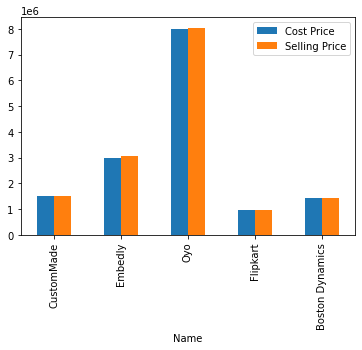

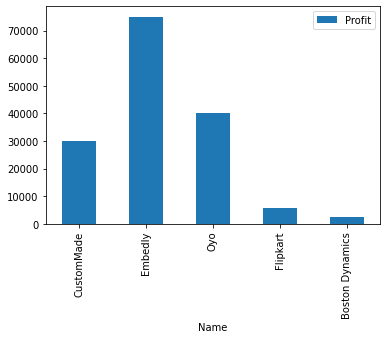

In [ ]:
ib_df = pd.DataFrame()
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("with IB_stock_sell_price as ( select s.security_id, s.corporateCo_id, (s.price_per_share + cast(u.fee_per_share as int))*s.total_quantity as sell_price  from dma.securities s join dma.underwriting u on s.security_id = u.security_id) select sp.corporateCo_id, c.name, co.net_revenue, sp.sell_price, (s.price_per_share* cast(s.total_quantity as int)) as cost_price, (sp.sell_price - (s.price_per_share* cast(s.total_quantity as int))) as total_profit from IB_stock_sell_price sp join dma.client c on sp.corporateCo_id = c.ID join dma.securities s on sp.security_id = s.security_id join dma.corporateCo co on c.ID = co.client_id;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        i=0
        while row:
            ib_df.loc[i,'Name'] = str(row[1])
            ib_df.loc[i,'Cost Price'] = row[4]
            ib_df.loc[i,'Selling Price'] = row[3]
            ib_df.loc[i,'Profit'] = row[5]
            i+=1
            i+=1
            print (str(row[0]) + " " + str(row[1]) + " " + str(row[2]) + " " + str(row[3]) + " " + str(row[4]) + " " + str(row[5]))
            row = cursor.fetchone()

ibplot = ib_df.plot(x="Name", y=["Cost Price", "Selling Price"], kind="bar")
ibplot2 = ib_df.plot(x="Name", y=["Profit"], kind="bar")


6) Find the running total of net revenue of each division over months

In [ ]:
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("select div_id, month, revenue, sum(revenue) over (partition by div_id order by month rows between unbounded preceding and current row) as runningtotal from dma.revenue;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        while row:
            print (str(row[0]) + " " + str(row[1]) + " " + str(row[2]) + " " + str(row[3]))
            row = cursor.fetchone()

['div_id', 'month', 'revenue', 'runningtotal']
1 2020-01-01 1000000000 1000000000
1 2020-02-01 1100000000 2100000000
1 2020-03-01 1200000000 3300000000
1 2020-04-01 1300000000 4600000000
1 2020-05-01 1400000000 6000000000
1 2020-06-01 1500000000 7500000000
1 2020-07-01 1600000000 9100000000
1 2020-08-01 1700000000 10800000000
1 2020-09-01 1800000000 12600000000
1 2020-10-01 1900000000 14500000000
1 2020-11-01 2000000000 16500000000
1 2020-12-01 2100000000 18600000000
1 2021-01-01 2200000000 20800000000
1 2021-02-01 2300000000 23100000000
1 2021-03-01 2400000000 25500000000
1 2021-04-01 2500000000 28000000000
1 2021-05-01 2600000000 30600000000
1 2021-06-01 2700000000 33300000000
1 2021-07-01 2800000000 36100000000
1 2021-08-01 2900000000 39000000000
1 2021-09-01 3000000000 42000000000
1 2021-10-01 3100000000 45100000000
1 2021-11-01 3200000000 48300000000
1 2021-12-01 3300000000 51600000000
1 2022-01-01 3400000000 55000000000
1 2022-02-01 3500000000 58500000000
1 2022-03-01 3600000000 

7) Identify the total quantity of securities that can be sold now by the commoners i.e. release date should not be after today's date. 

In [ ]:
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("select sp.security_id, sum(quantity) ready_to_sell_quantity from dma.security_purchase sp where DATEDIFF(day, CAST( GETDATE() AS Date ), release_date) > 0 group by sp.security_id;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        while row:
            print (str(row[0]) + " " + str(row[1]))
            row = cursor.fetchone()

['security_id', 'ready_to_sell_quantity']
100001 780
200002 325
300003 184
500005 184


8) What are the mean, min, max and range of salaries of employees in each division? Display the name of the division and the number of employees in each division.

In [ ]:
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("select d.NAME, avg(e.compensation) as mean_salary, min(e.compensation) as min_salary, max(e.compensation) as max_salary, max(e.compensation) - min(e.compensation) as range, count(*) as num_of_employees from dma.employee e join dma.division d on e.div_id=d.ID GROUP by d.NAME;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        while row:
            print (str(row[0]) + " " + str(row[1]) + " " + str(row[2]) + " " + str(row[3]) + " " + str(row[4]) + " " + str(row[5]))
            row = cursor.fetchone()

['NAME', 'mean_salary', 'min_salary', 'max_salary', 'range', 'num_of_employees']
Asset Management 188527 115753 278131 162378 7
Investment Banking 209513 102294 300000 197706 8
Private and Corporate 208986 114220 298792 184572 8
Wealth Management 223477 120715 300000 179285 7


9) Identify how many employees work for each manager. Disply the name of the manager, age, salary and the count.

In [ ]:
with pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+password) as conn:
    with conn.cursor() as cursor:
        cursor.execute("with emp_count as ( select manager_id, count(*) as no_of_employees from dma.employee group by manager_id except (select manager_id, count(*) from dma.employee where manager_id is null group by manager_id)) select e.ID, e.name, e.compensation, c.no_of_employees from dma.employee e join emp_count c on e.ID = c.manager_id;")
        columns = [column[0] for column in cursor.description]
        print(columns)
        row = cursor.fetchone()
        while row:
            print (str(row[0]) + " " + str(row[1]) + " " + str(row[2]) + " " + str(row[3]))
            row = cursor.fetchone()

['ID', 'name', 'compensation', 'no_of_employees']
4 Venkat Krishnamurthy 300000 7
5 Bridgett Kovach 114220 7
7 Lexis Lofton 270000 6
10 Daniela Ceja 300000 6


#Application of Machine Learning on the Revenue Data to predict future revenues.

---



connection created
          date       revenue
0   2020-01-01  1.000000e+09
1   2020-02-01  1.100000e+09
2   2020-03-01  1.200000e+09
3   2020-04-01  1.300000e+09
4   2020-05-01  1.400000e+09
5   2020-06-01  1.500000e+09
6   2020-07-01  1.600000e+09
7   2020-08-01  1.700000e+09
8   2020-09-01  1.800000e+09
9   2020-10-01  1.900000e+09
10  2020-11-01  2.000000e+09
11  2020-12-01  2.100000e+09
12  2021-01-01  2.200000e+09
13  2021-02-01  2.300000e+09
14  2021-03-01  2.400000e+09
15  2021-04-01  2.500000e+09
16  2021-05-01  2.600000e+09
17  2021-06-01  2.700000e+09
18  2021-07-01  2.800000e+09
19  2021-08-01  2.900000e+09
20  2021-09-01  3.000000e+09
21  2021-10-01  3.100000e+09
22  2021-11-01  3.200000e+09
23  2021-12-01  3.300000e+09
24  2022-01-01  3.400000e+09
25  2022-02-01  3.500000e+09
26  2022-03-01  3.600000e+09
27  2022-04-01  3.700000e+09
28  2022-05-01  3.800000e+09
29  2022-06-01  3.900000e+09
30  2022-07-01  4.000000e+09
31  2022-08-01  4.100000e+09
32  2022-09-01  4.200000

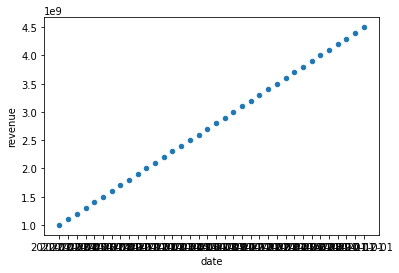

In [ ]:
#retrieving Wealth Management Revenue Data from database and saving in a dataframe.
wm_df = pd.DataFrame()
with pyodbc.connect(conn_string) as conn:
    with conn.cursor() as cursor:
        print('connection created')
        cursor.execute("select * from dma.revenue where div_id=1")
        row = cursor.fetchone()
        i=0
        while row:
            wm_df.loc[i,'date'] = str(row[1])
            wm_df.loc[i,'revenue'] = row[2]
            i+=1
            row = cursor.fetchone()
print(wm_df)
wmdf_temp = wm_df
wmdf_temp.plot(x="date", y="revenue", kind='scatter')

In [ ]:
#converting string type date to datetime and then to ordinal.
import datetime as dt
wmdf_temp['date'] = pd.to_datetime(wmdf_temp['date'])
wmdf_temp['date']=wmdf_temp['date'].map(dt.datetime.toordinal)
wmdf_temp

,date,revenue
0,737425,1.000000e+09
1,737456,1.100000e+09
2,737485,1.200000e+09
3,737516,1.300000e+09
4,737546,1.400000e+09
5,737577,1.500000e+09
6,737607,1.600000e+09
7,737638,1.700000e+09
8,737669,1.800000e+09
9,737699,1.900000e+09


In [ ]:
X = np.array(wmdf_temp['date']).reshape(-1, 1)
y = np.array(wmdf_temp['revenue']).reshape(-1, 1)
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
# Splitting the data into training and testing data

regr = LinearRegression()
  
regr.fit(X_train, y_train)
print("Model Accuracy: ",regr.score(X_test, y_test))

Model Accuracy:  0.99999557798502


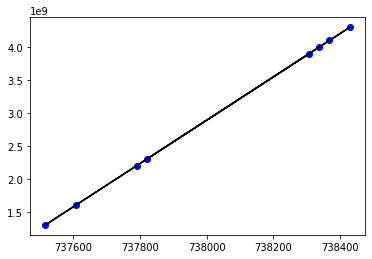

In [ ]:
y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color ='b')
plt.plot(X_test, y_pred, color ='k')
  
plt.show()

In [ ]:
predicted_revenue = regr.predict([[pd.to_datetime('2023-01-01').toordinal()]])
print(predicted_revenue[0,0])

4601842137.095703
